# 论文题目：Improving the Performance of Deep Quantum Optimization Algorithms with Continuous Gate Sets

## 项目介绍：
QAOA算法可用于解决精确覆盖问题，相对应的量子电路主要由初态电路和ansatz电路组成。其中，ansatz又分为UC(gamma)和UB(beta)两部分子电路，gamma和beta是待训练参数，一个UC电路和一个UB电路共同构成ansatz的一个子电路。随着算法层数p的增加，ansatz中需要不断重复p次这样的子电路，也就是ansatz = p * (UC + UB)。

一般的量子电路中，将第i个和第j个量子比特之间的一个UC电路，设置成一个旋转Z门、两个CZ门和四个H门，即$$Uij = H(j) + CZ(i,j) + H(j) + PhaseShift(j) + H(j) + CZ(i,j) + H(j)$$

 本论文对UC电路进行了改进，引进了新的门$$CZ\varphi = [[1,0,0,0][0,1,0,0][0,0,1,0][0,0,0,exp(-i\varphi)]]$$
 据此，UC部分可简化为两个旋转Z门和一个受控旋转门CZφ，即$$UCij = PhaseShift(i) + PhaseShift(j) + PhaseShift(i,j)$$
 （本论文的旋转Z门实际上对应mindquantum中的PhaseShift门，而非RZ门）。

进行了以上优化后，每个UCij中的门的数量减少了，整个p层的ansatz线路中的门数量也就显著减少了，并且序列持续时间也减少了，由此就可提高算法的性能。

## 复现目标：
1、利用MindQuantum复现论文中提到的QAOA算法；
2、复现论文图3中的结果。

## 复现过程
1、导入相关包

In [11]:
# -*- coding: utf-8 -*-
from mindquantum.core import Circuit, Hamiltonian, X, UN, H, RX, RY, RZ, QubitOperator, PhaseShift
from mindquantum.framework import MQAnsatzOnlyLayer
from mindquantum.simulator import Simulator
import mindspore.nn as nn
import numpy as np
import mindspore as ms
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## 复现过程
2、本论文中的精确覆盖问题的情形如下，

集合S={x1, x2, x3}，子集S1={x1}，S2={x2, x3}，S3={x1, x2, x3}，

对应的关联矩阵为$$[[1,0,1] [0,1,1] [0,1,1]]$$
其中，第i行表示元素xi，第j列表示子集Sj，第i行第j列为1表示元素xi在子集Sj中，否则为0。

要求找到集合S基于子集S1，S2，S3的一个划分，使得每个元素在这个划分中出现并只出现一次。

针对此矩阵，问题的正解有两个，即{S1, S2}或{S3}。如果用三位量子比特来表示解，第i位为1表示选中第i个子集，否则为0，则正解可分别表示为|110>和|001>。

In [12]:
# 初始化一个3*3的零矩阵
k = np.zeros((3,3), dtype = np.int)
# 在关联矩阵中添加覆盖
k[0][0] = 1
k[0][2] = 1
k[1][1] = 1
k[1][2] = 1
k[2][1] = 1
k[2][2] = 1
print(k)

[[1 0 1]
 [0 1 1]
 [0 1 1]]


get_Jij、get_klj和get_hi都是用于计算系数的辅助函数。
计算公式分别如下：

$$Jij = \sum_{l=1}^n (Kli * Klj / 2)$$

$$hi =  \sum_{l=1}^n (Kli * (-1 + 1/2 *  \sum_{j=1}^n (Klj)))$$

本论文中，所有hi实际算出来都是0.

In [13]:
#根据关联矩阵k，计算系数Jij
def get_Jij(i, j, k):
    Jij = 0
    for l in range(k.shape[0]):
        Jij += k[l][i] * k[l][j] * 0.5
    return Jij

#计算第l行的klj之和
def get_klj(l, k):
    klj = 0
    for j in range(k.shape[1]):
        klj += k[l][j]
    return klj

#根据关联矩阵k，计算系数hi
def get_hi(i, k):
    hi = 0
    for l in range(k.shape[0]):
        hi += k[l][i] * (-1 + 0.5 * get_klj(l, k))
    return hi

build_UC是用于搭建UC部分量子线路的函数。

UCij表示第i个和第j个量子比特之间的UC电路，

其构成为$$UCij = PhaseShift(i, 2 * \gamma * Jij) + PhaseShift(j, 2 * \gamma * Jij) + PhaseShift(i, j, -4 * \gamma * Jij)$$
即两个单量子PhaseShift门和一个双量子PhaseShift门，其中gamma是第p层的待训练参数gamma。

In [14]:
# 搭建UC(gamma)对应的量子线路
def build_UC(k, g, para):
    # 创建量子线路
    UC = Circuit()
    for j in range(k.shape[1]):
        for i in range(j):
            Jij = get_Jij(i, j, k)
            # UCij = Phase(i, 2 * gamma * Jij) + Phase(j, 2 * gamma * Jij) + Phase(i, j, 4 * gamma * Jij)
            # i < j
            if(g==''):
                UC += PhaseShift({para: 2*Jij }).on(i)
                UC += PhaseShift({para: 2*Jij }).on(j)
                UC += PhaseShift({para: -4 * Jij }).on(j, i)
            else:
                UC += PhaseShift(2 * Jij * g).on(i)
                UC += PhaseShift(2 * Jij * g).on(j)
                UC += PhaseShift(-4 * Jij * g).on(j, i)
    # 添加Barrier以方便展示线路
    UC.barrier()
    return UC

build_UB是用于搭建UB部分量子线路的函数。

UBi表示第i个量子比特上的UB电路，

其构成为$$UBi = RX(2 * \beta)$$

即每个量子比特上作用一个RX门，其中beta是第p层的待训练参数beta。

In [15]:
# 搭建UB(β)对应的量子线路：
def build_UB(k, b, para):
    # 创建量子线路
    UB = Circuit()
    for i in range(k.shape[1]):
        if(b==''):
            # 对每个节点作用RX门
            UB += RX({para:2}).on(i)
        else:
            UB += RX(2 * b).on(i)
    # 添加Barrier以方便展示线路
    UB.barrier()
    return UB

build_HC是用来生成哈密顿量的函数，输入为一个关联矩阵，

哈密顿量的计算公式为$$HC =  \sum_{i<j} (Jij * Zi * Zj) +  \sum_{i=1}^n (hi * Zi)$$

本论文中的所有hi实际计算结果都为0.

In [16]:
# 构建哈密顿量HC
def build_HC(k):
    # 生成哈密顿量HC
    HC = QubitOperator()
    # HC = Sigma(Jij * Zi * Zj) + Sigma(hi * Zi)
    for j in range(k.shape[1]):
        for i in range(j):
            HC += get_Jij(i, j, k) * QubitOperator(f'Z{i} Z{j}')
    for i in range(k.shape[1]):
        HC += get_hi(i, k) * QubitOperator(f'Z{i}')
    return HC

build_ansatz用于搭建多层算法的ansatz线路，

一层ansatz包括一个UC电路和一个UB电路，层数p增加时，重复p次单层ansatz电路即可得到完整ansatz电路。

In [17]:
# 搭建多层的训练网络
# p是ansatz线路的层数
def build_ansatz(k, p, g, b):
    # 创建量子线路
    circ = Circuit()
    for i in range(p):
        # 添加UC对应的线路，参数记为g0、g1、g2...
        circ += build_UC(k, g, f'g{i}')
        # 添加UB对应的线路，参数记为b0、b1、b2...
        circ += build_UB(k, b, f'b{i}')

    return circ

## 复现过程
3、开始构建量子线路。（具体步骤其实在注释中已经写明了）

In [18]:
# pylint: disable=W0104
# QAOA量子线路的层数p
p = 1
# 生成初态（均匀叠加态），即对所有量子比特作用H门
init_state_circ = UN(H, k.shape[1])
# 生成哈密顿量
ham = Hamiltonian(build_HC(k))
# 构建ansatz线路
ansatz = build_ansatz(k, p, '', '')
# 组合成完整线路
circ = init_state_circ + ansatz
ms.context.set_context(mode=ms.context.PYNATIVE_MODE, device_target="CPU")
# 生成一个基于projectq后端的模拟器，并设置模拟器的比特数为量子线路的比特数
sim = Simulator('projectq', circ.n_qubits)
# 获取模拟器基于当前量子态的量子线路演化以及期望、梯度求解算子
grad_ops = sim.get_expectation_with_grad(ham, circ)

## 复现过程
下面先开始论文图3中几张图像的复现，针对论文中三量子比特的精确覆盖问题最终运行结果在最末尾。

图3所有图像都是在算法深度p=1，量子比特数量为3，关联矩阵如同k所示的情况下的图像。

根据对模拟器Simulator和数据处理之间的关系，以下几张图并未按1, 2, ... , 6 的顺序进行。

1、一二两张图都是损失函数Cost(gamma, beta)的heatmap图，

原文中的第一张图应该是在低温超导量子设备上的实验数据，原文中的第二张图是模拟数据。

因此复现时的一二两张图其实都是模拟数据，计算方式也一样。

本论文中，$$Cost(\gamma,\beta)=<\gamma,\beta| HC |\gamma,\beta>$$

可以根据模拟器simulator基于当前量子态的求解算子grad_ops进行计算。

图上可以观察到，图像被分为了左侧一上一下两个分界明显的区域，以及右侧田字形的四个区域。

复现结果与论文中一致。

2、图3和图5分别是从随机初始参数开始，对gamma和beta进行优化的收敛迹。

图上可以观察到，gamma收敛于pi/4，beta收敛于pi/8和pi*3/8，这与heatmap图中的聚点相对应。

3、图4是在指定beta的值为pi/8 或pi*3/8 时，损失函数cost随gamma的变化关系，

图上可以观察到，两条曲线关于cost=0 的横轴上下对称。这也满足heatmap中所显示的值的大小、beta周期性关系，beta关于pi/4对称。

4、图6对应于图2和图4的gamma与beta条件，显示了从随机初始参数开始，损失函数cost的收敛迹。

共十条彩色线条，全部逐渐收敛于cost=-1，黑色线条为十组损失函数cost的平均值。

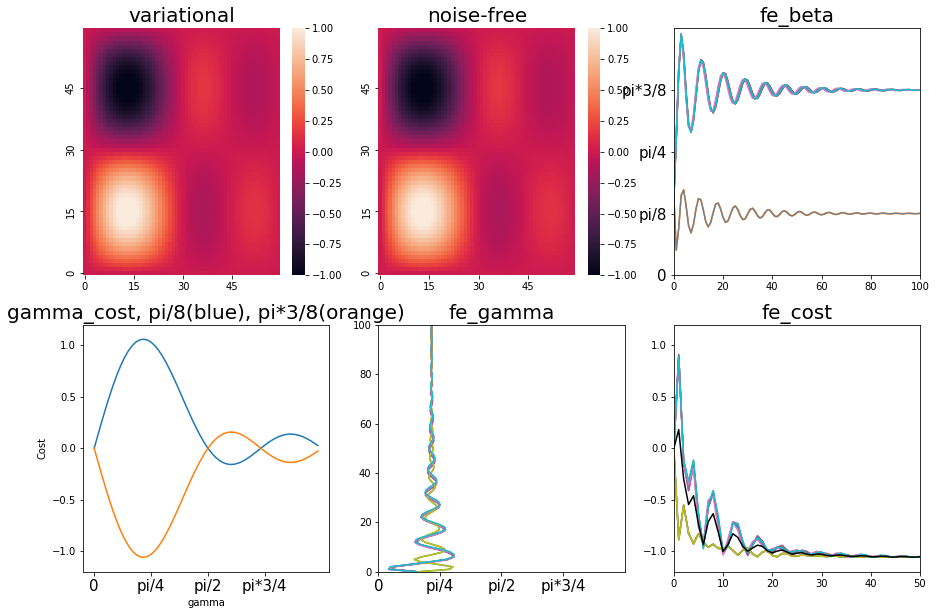

In [19]:
plt.figure(figsize=(15, 10))

# 第一张图
step = 60
beta_max = np.pi/2
beta_step = beta_max / step
gamma_max = np.pi
gamma_step = gamma_max / step
beta = np.arange(0, beta_max, beta_step)
gamma = np.arange(0, gamma_max, gamma_step)
costs = np.zeros((beta.size, gamma.size), dtype=np.float64)

for i in range(beta.size):
    for j in range(gamma.size):
        bg = np.array([gamma[j], beta[i]])
        cost, grad = grad_ops(bg)
        costs[i][j] = cost[0][0]

plt.subplot(231)
plt.title("variational",fontsize = 20)
plt.xlim((0, np.pi/2))
plt.ylim((0, np.pi))
sns.heatmap(data=costs, vmin=-1, vmax=1, xticklabels=15, yticklabels=15).invert_yaxis()

# 第五张图
plt.subplot(235)
plt.title("fe_gamma",fontsize = 20)
plt.ylim((0, 100))
plt.xlim((0, np.pi))
plt.xticks([0, np.pi/4, np.pi/2, np.pi*3/4],['0', 'pi/4','pi/2','pi*3/4'], fontsize=15)

data = np.zeros((200,10,4), dtype = np.float64)
for j in range(10):
    grad_ops = sim.get_expectation_with_grad(ham, circ)
    net = MQAnsatzOnlyLayer(grad_ops)
    opti = nn.Adam(net.trainable_params(), learning_rate=0.5)
    train_net = nn.TrainOneStepCell(net, opti)
    for i in range(200):
        loss = train_net().asnumpy()
        data[i][j][0] = i
        data[i][j][1] = net.weight.asnumpy()[0]
        data[i][j][2] = net.weight.asnumpy()[1]
        data[i][j][3] = loss

for i in range(10):
    fe = data[ : , i]
    fe = pd.DataFrame(fe, columns=['fe','gamma','beta', 'cost'])
    plt.plot(fe['gamma'],fe['fe'])

# 第四张图
plt.subplot(234)
plt.title("gamma_cost, pi/8(blue), pi*3/8(orange)",fontsize = 20)
plt.xlabel('gamma')
plt.ylabel('Cost')
plt.ylim((-1.2, 1.2))
plt.xticks([0, np.pi/4, np.pi/2, np.pi*3/4],['0', 'pi/4','pi/2','pi*3/4'], fontsize=15)

costs = np.zeros((gamma.size,2), dtype=np.float64)
for i in range(gamma.size):
    ansatz = build_ansatz(k, p, '', np.pi/8)
    circ = init_state_circ + ansatz
    sim = Simulator('projectq', circ.n_qubits)
    grad_ops = sim.get_expectation_with_grad(ham, circ)
    g = np.array([gamma[i]])
    cost, grad = grad_ops(g)
    costs[i][0] = gamma[i]
    costs[i][1] = cost[0][0]

costs = pd.DataFrame(costs, columns=['gamma','cost'])
plt.plot(costs['gamma'], costs['cost'])

costs = np.zeros((gamma.size,2), dtype=np.float64)
for i in range(gamma.size):
    ansatz = build_ansatz(k, p, '', np.pi*3/8)
    circ = init_state_circ + ansatz
    sim = Simulator('projectq', circ.n_qubits)
    grad_ops = sim.get_expectation_with_grad(ham, circ)
    g = np.array([gamma[i]])
    cost, grad = grad_ops(g)
    costs[i][0] = gamma[i]
    costs[i][1] = cost[0][0]

costs = pd.DataFrame(costs, columns=['gamma','cost'])
plt.plot(costs['gamma'], costs['cost'])


# 第六张图
plt.subplot(236)
plt.title("fe_cost",fontsize = 20)
plt.xlim((0, 50))
plt.ylim((-1.2, 1.2))

costs = np.zeros((200,1), dtype=np.float64)
costs = pd.DataFrame(costs, columns=['cost'])
for i in range(10):
    fe = data[ : , i]
    fe = pd.DataFrame(fe, columns=['fe','gamma','beta', 'cost'])
    costs['cost'] += fe['cost']
    plt.plot(fe['fe'], fe['cost'])

costs['cost'] /= 10
plt.plot(fe['fe'], costs['cost'], color = 'k')

# 第三张图
plt.subplot(233)
plt.title("fe_beta",fontsize = 20)
plt.xlim((0, 100))
plt.ylim((0, np.pi/2))
plt.yticks([0, np.pi/8, np.pi/4, np.pi*3/8],['0', 'pi/8','pi/4','pi*3/8'], fontsize=15)

for i in range(10):
    fe = data[ : , i]
    fe = pd.DataFrame(fe, columns=['fe','gamma','beta', 'cost'])
    plt.plot(fe['fe'], fe['beta'])

#第二张图
plt.subplot(232)
plt.title("noise-free",fontsize = 20)
plt.xlim((0, np.pi/2))
plt.ylim((0, np.pi))

costs = np.zeros((beta.size, gamma.size), dtype=np.float64)
for i in range(beta.size):
    for j in range(gamma.size):
        ansatz = build_ansatz(k, p, gamma[j], beta[i])
        circ = init_state_circ + ansatz
        sim = Simulator('projectq', circ.n_qubits)
        grad_ops = sim.get_expectation_with_grad(ham, circ)
        gb = np.array([])
        cost, grad = grad_ops(gb)
        costs[i][j] = cost[0][0]

sns.heatmap(data=costs, vmin=-1, vmax=1, xticklabels=15, yticklabels=15).invert_yaxis()

## 复现过程
最后，在根据论文改进之处构造出的量子线路上，进行模拟与参数训练，得到的最优gamma与beta参数代入电路后，运行1000次，得到的解的分布情况如下列柱状图所示。

开头提到了，本论文中所用示例的正解有两个，分别是|110>和|001>。可以看到，模拟电路运行结果也有约一半的概率显示|110>，一半的概率显示|001>。

In [20]:
# pylint: disable=W0104
# QAOA量子线路的层数p
p = 4
# 生成初态（均匀叠加态），即对所有量子比特作用H门
init_state_circ = UN(H, k.shape[1])
# 生成哈密顿量
ham = Hamiltonian(build_HC(k))
# ansatz是求解该问题的量子线路
ansatz = build_ansatz(k, p, '', '')
# 将初始化线路与ansatz线路组合成一个线路
circ = init_state_circ + ansatz

ms.context.set_context(mode=ms.context.PYNATIVE_MODE, device_target="CPU")
# 生成一个基于projectq后端的模拟器，并设置模拟器的比特数为量子线路的比特数
sim = Simulator('projectq', circ.n_qubits)
# 获取模拟器基于当前量子态的量子线路演化以及期望、梯度求解算子
grad_ops = sim.get_expectation_with_grad(ham, circ)
# 生成待训练的神经网络
net = MQAnsatzOnlyLayer(grad_ops)
# 设置针对网络中所有可训练参数、学习率为0.05的Adam优化器
opti = nn.Adam(net.trainable_params(), learning_rate=0.2)
# 对神经网络进行一步训练，TrainOneStepCell的返回值是loss
train_net = nn.TrainOneStepCell(net, opti)
# 训练200次
for i in range(200):
    train_net()

# 将最优参数提取出来并存储为字典类型，与之前线路中命名的参数一一对应
pr = dict(zip(ansatz.params_name, net.weight.asnumpy()))
# 为线路中所有比特添加测量门
circ.measure_all()
# 将最优参数代入量子线路，通过对量子线路进行1000次采样，画出最终量子态在计算基矢下的概率分布
sim.sampling(circ, pr=pr, shots=1000)

shots: 1000
Keys: q2 q1 q0│0.00   0.128       0.257       0.385       0.513       0.641
──────────────┼───────────┴───────────┴───────────┴───────────┴───────────┴
           011│▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
              │
           100│▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒
              │
{'011': 513, '100': 487}

## 项目总结
至此，本论文的两个复现目标基本完成。

对于QAOA算法解决精确覆盖问题，本论文提出的改进线路，每层的每个UCij线路可减少几个量子门，当量子比特位数增多时，UCij的数量就会增多，且算法深度p增加时，整个UC电路的层数也会增加，结合以上两点，本论文的改进可以有效减少门数量、降低序列持续时间，由此提高算法性能。

另外，本论文的改进之处只涉及到第i个和第j个量子比特之间的UCij电路，多个UC电路、UC电路与其他电路之间并无明显约束关系，故我认为，本论文所提方法的可扩展性还是比较强的，不仅是量子比特数目上的扩展，还包括算法层数p的扩展性。